<a href="https://colab.research.google.com/github/jeanmhuang/quant-projects/blob/main/portfolio_optimization_efficient_frontier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install yfinance if needed
!pip install yfinance --quiet

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Select 3 assets for the portfolio
tickers = ['AAPL', 'MSFT', 'GOOGL']

# Download daily closing prices
data = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Preview the data
returns.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,GOOGL,MSFT
Date,,,
2020-01-03,-0.009722,-0.005231,-0.012452
2020-01-06,0.007968,0.026654,0.002585
2020-01-07,-0.004703,-0.001932,-0.009118
2020-01-08,0.016086,0.007118,0.015929
2020-01-09,0.021241,0.010498,0.012493


In [2]:
# Initialize variables
num_portfolios = 10000
results = np.zeros((3, num_portfolios))  # rows: return, volatility, Sharpe
weights_record = []

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Simulate portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # normalize to 1
    weights_record.append(weights)

    # Expected return and volatility
    annual_return = np.sum(mean_returns * weights) * 252
    annual_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)

    # Sharpe ratio (risk-free rate assumed 0)
    sharpe_ratio = annual_return / annual_volatility

    results[0, i] = annual_return
    results[1, i] = annual_volatility
    results[2, i] = sharpe_ratio

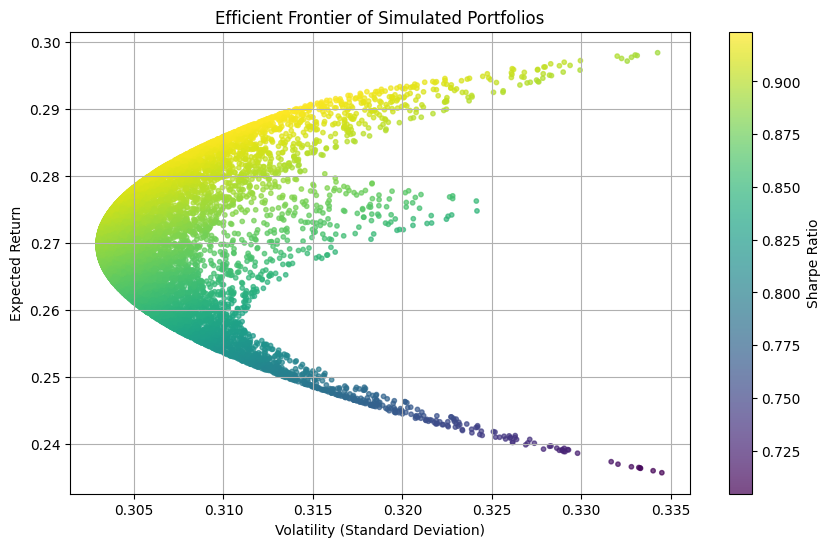

In [3]:
# Plot Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.7)
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier of Simulated Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [4]:
from scipy.optimize import minimize

# Define functions to calculate return, volatility, and Sharpe
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.sum(weights * mean_returns) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return ret, vol

def negative_sharpe_ratio(weights, mean_returns, cov_matrix):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    return -ret / vol  # we minimize the negative Sharpe

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for _ in range(len(tickers)))

# Initial guess: equal weighting
initial_guess = len(tickers) * [1. / len(tickers)]

# Optimize
opt_result = minimize(negative_sharpe_ratio, initial_guess,
                      args=(mean_returns, cov_matrix),
                      method='SLSQP', bounds=bounds, constraints=constraints)

# Output optimal weights and Sharpe
opt_weights = opt_result.x
opt_ret, opt_vol = portfolio_performance(opt_weights, mean_returns, cov_matrix)
opt_sharpe = opt_ret / opt_vol

print("Sharpe-Optimal Portfolio Weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {opt_weights[i]:.2%}")

print(f"\nExpected Return: {opt_ret:.2%}")
print(f"Volatility: {opt_vol:.2%}")
print(f"Sharpe Ratio: {opt_sharpe:.2f}")

Sharpe-Optimal Portfolio Weights:
AAPL: 59.64%
MSFT: 0.00%
GOOGL: 40.36%

Expected Return: 28.97%
Volatility: 31.36%
Sharpe Ratio: 0.92


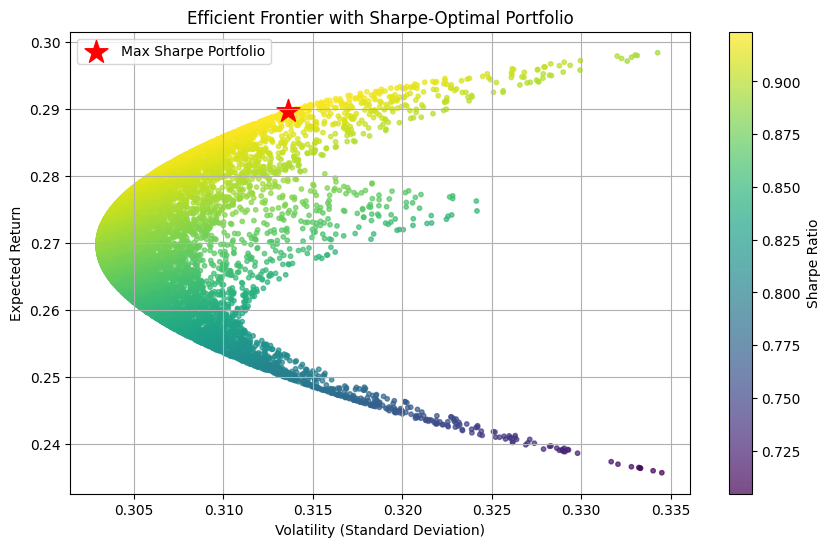

In [5]:
# Plot all simulated portfolios
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', s=10, alpha=0.7)
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Sharpe-Optimal Portfolio')
plt.colorbar(label='Sharpe Ratio')

# Plot the optimal portfolio as a red star
plt.scatter(opt_vol, opt_ret, color='red', marker='*', s=300, label='Max Sharpe Portfolio')

plt.legend()
plt.grid(True)
plt.show()